In [97]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


(528, 1152, 3)


Text(0.5, 1.0, 'Query image')

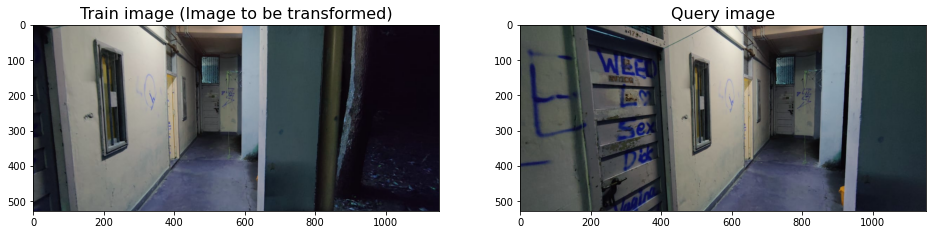

In [98]:
trainImg = cv2.imread('dataset/3/2.jpeg')
trainImg_gray = cv2.cvtColor(trainImg, cv2.COLOR_RGB2GRAY)
print("Image shape:", trainImg.shape)

queryImg = cv2.imread('dataset/3/1.jpeg')
queryImg_gray = cv2.cvtColor(queryImg, cv2.COLOR_RGB2GRAY)

fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax[0].imshow(trainImg)
ax[0].set_title("Train image (Image to be transformed)", fontsize=16)

ax[1].imshow(queryImg)
ax[1].set_title("Query image", fontsize=16)


In [99]:
descriptor = cv2.ORB_create()
kpsA, featuresA = descriptor.detectAndCompute(trainImg_gray, None)
kpsB, featuresB = descriptor.detectAndCompute(queryImg_gray, None)


# Corresponding points visualization


Text(0.5, 1.0, '(b)')

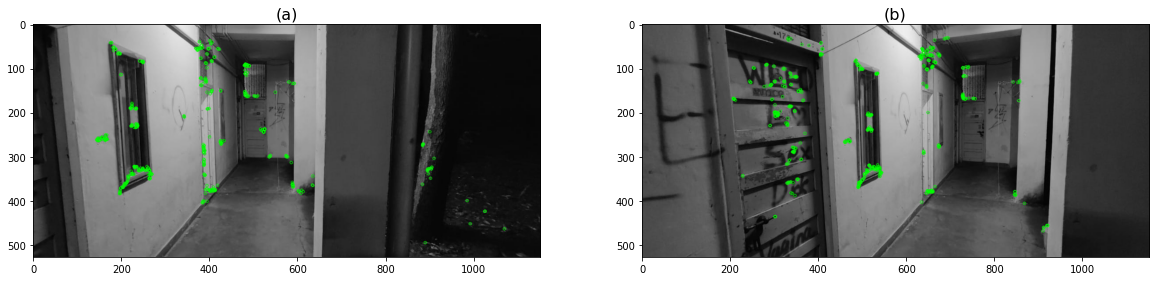

In [104]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)

ax[0].imshow(cv2.drawKeypoints(trainImg_gray,kpsA,None,color=(0,255,0)))
ax[0].set_title("(a)", fontsize=16)

ax[1].imshow(cv2.drawKeypoints(queryImg_gray, kpsB, None, color=(0,255,0)))
ax[1].set_title("(b)", fontsize=16)


# Bruteforce matching


Raw matches (Brute force): 207


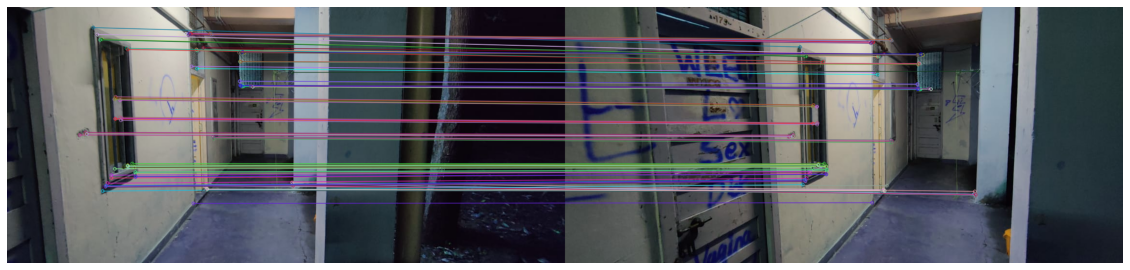

In [110]:
# ? Brute force
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# ? Match descriptors
rawMatches = bf.match(featuresA, featuresB)

# ? Sort the features in order of distance.
# ? The points with small distance (more similarity) are ordered first in the vector
matches = sorted(rawMatches, key=lambda x: x.distance)
print("Raw matches (Brute force):", len(matches))

# ? matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
img3 = cv2.drawMatches(
    trainImg,
    kpsA,
    queryImg,
    kpsB,
    matches[:100],
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)

plt.figure(figsize=(20, 10))
plt.imshow(img3)
plt.axis("off")
plt.show()


# KNN matching


Raw matches (knn): 500


(-0.5, 2303.5, 527.5, -0.5)

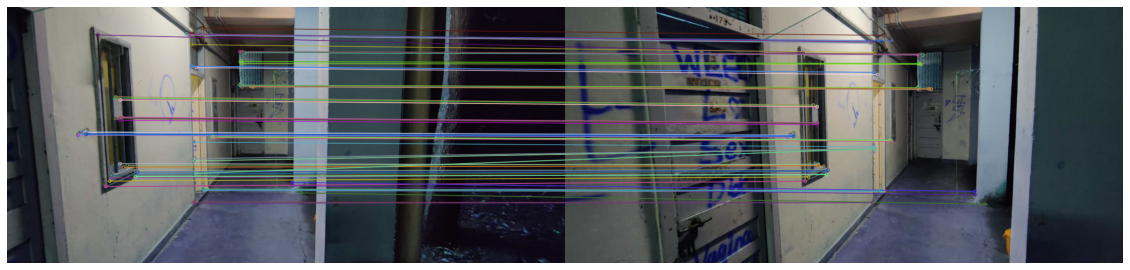

In [112]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

# ? compute the raw matches and initialize the list of actual matches
rawMatches = bf.knnMatch(featuresA, featuresB, 2)
print("Raw matches (knn):", len(rawMatches))

matches = []
ratio = 0.75

# ? loop over the raw matches and ensure the distance is within
# ? a certain ratio of each other (i.e. Lowe's ratio test)
for m, n in rawMatches:
    if m.distance < n.distance * ratio:
        matches.append(m)

# 
# ? matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
img3 = cv2.drawMatches(
    trainImg,
    kpsA,
    queryImg,
    kpsB,
    np.random.choice(matches,100),
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)

plt.figure(figsize=(20, 10))
plt.imshow(img3)
plt.axis("off")


In [93]:
assert len(matches) > 4, "Not enough matches"

# ? convert the keypoints to numpy arrays
kpsA = np.float32([kp.pt for kp in kpsA])
kpsB = np.float32([kp.pt for kp in kpsB])

# ? construct the two sets of points
ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
ptsB = np.float32([kpsB[m.trainIdx] for m in matches])

# ? estimate the homography between the sets of points
H, status = cv2.findHomography(
    ptsA, ptsB, cv2.RANSAC, ransacReprojThreshold=4
)
print(H)


[[ 3.31753641e-01 -2.22094698e-02  3.79209536e+02]
 [-1.34464931e-01  7.52487899e-01  6.65402828e+01]
 [-5.47441034e-04 -9.52025328e-06  1.00000000e+00]]


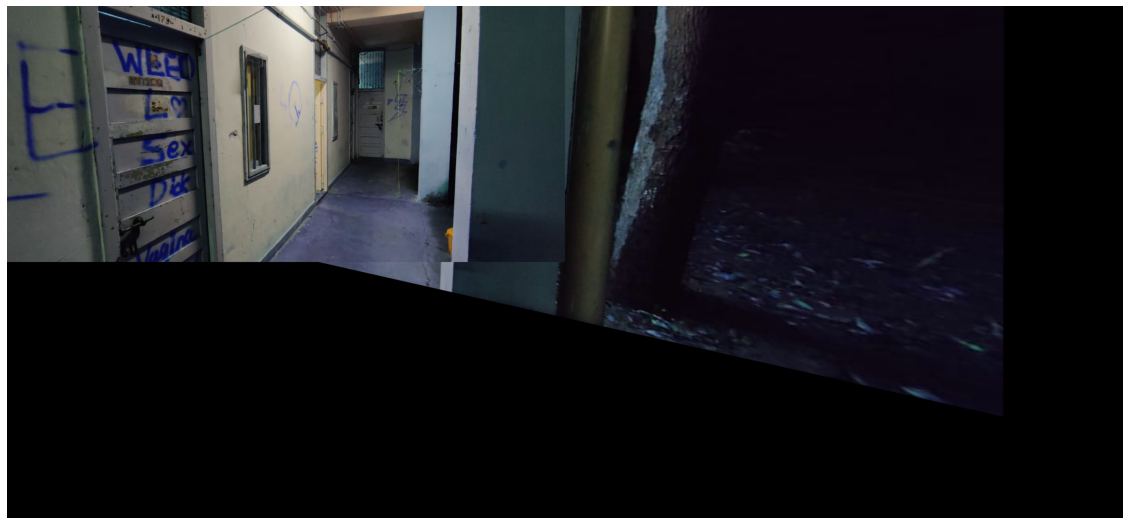

In [108]:
height = trainImg.shape[0] + queryImg.shape[0]
width = trainImg.shape[1] + queryImg.shape[1]

result = np.zeros((height, width, 3), dtype=np.uint8)
result = cv2.warpPerspective(trainImg, H, (width, height))
result[0 : queryImg.shape[0], 0 : queryImg.shape[1]] = queryImg

plt.figure(figsize=(20, 10))
plt.imshow(result)
plt.axis("off")
plt.show()
